In [3]:
import torch
import numpy as np
from scipy.stats import beta
from utils import load_data
import matplotlib.pyplot as plt
import seaborn as sns

from clstm import cLSTM, train_model_gista, train_model_adam

ModuleNotFoundError: No module named 'clstm'

In [ ]:
mice = load_data()

In [ ]:
heatmaps = []
def evaluate(n_hidden, lr_scale, lam_scale, lam_ridge_scale, truncation, data=X_torch_abs, max_iter=2500):
    """ 
    Evaluate a given set of hyperparameters, training a model for 2500 epochs
    and returning a score.
    
    This is the black-box function which our Bayesian Optimization algorithm
    will attempt to optimize
    """
    # transform continues values into valid hyperparams
    n_hidden = int(n_hidden + .5)
    truncation = int(truncation + .5)
    lr = 10**lr_scale
    lam = 10**lam_scale
    lam_ridge = 10**lam_ridge_scale
    
    # train the model
    gcmodel = cLSTM(p, n_hidden)
    gcmodel.to('cuda')
    train_loss_list, train_mse_list = train_model_gista(
        gcmodel,
        data.to('cuda'),
        lam=lam,
        lam_ridge=lam_ridge,
        lr=lr,
        max_iter=max_iter,
        check_every=100,
        truncation=truncation,
        verbose=0
    )
    gc = gcmodel.GC(threshold=False).cpu().detach().numpy()
    heatmaps.append(gc)
    eval_heatmaps.append(gc)
    gc_thresh = (heatmaps[-1] > 0).astype('float')
    
    # return the resulting model's score
    return get_gc_score(gc_thresh)

Now that we've done our hyperparameter search, we will repeat the experiment with a better-calibrated model for the same 20 bugs across each of the 9 mice. We'll store the GC values in the `heatmaps` array so that we can compare their interactions across experiments.

In [2]:
for i, mouse in mice.items():
    print(f'Mouse {i}')
    # percent reads / times
    mouse2_abs = mouse['reads_abs_mean']
    top_reads_abs = mouse2_abs[IMP_READS, :].T

    mean_abs = np.mean(top_reads_abs, axis=0)
    std_abs = np.std(top_reads_abs, axis=0)
    top_reads_abs = (top_reads_abs - mean_abs) / std_abs

    X_torch_abs = torch.tensor(top_reads_abs[np.newaxis], dtype=torch.float32)
    print(X_torch_abs.shape)
    score = evaluate(**optimizer.max['params'], data=X_torch_abs)
    print(score, '\n')

NameError: name 'mice' is not defined

In [ ]:
heatmaps = np.array(heatmaps)

In [259]:
# np.save('all_mice_heatmaps', heatmaps)

Now we can see the GC values for each of the mice. Note that mice 2-5 correspond to healthy patients and mice 6-10 correspond to patients with IBD. Notably, the distribution of GC values looks much more similar within these groups.

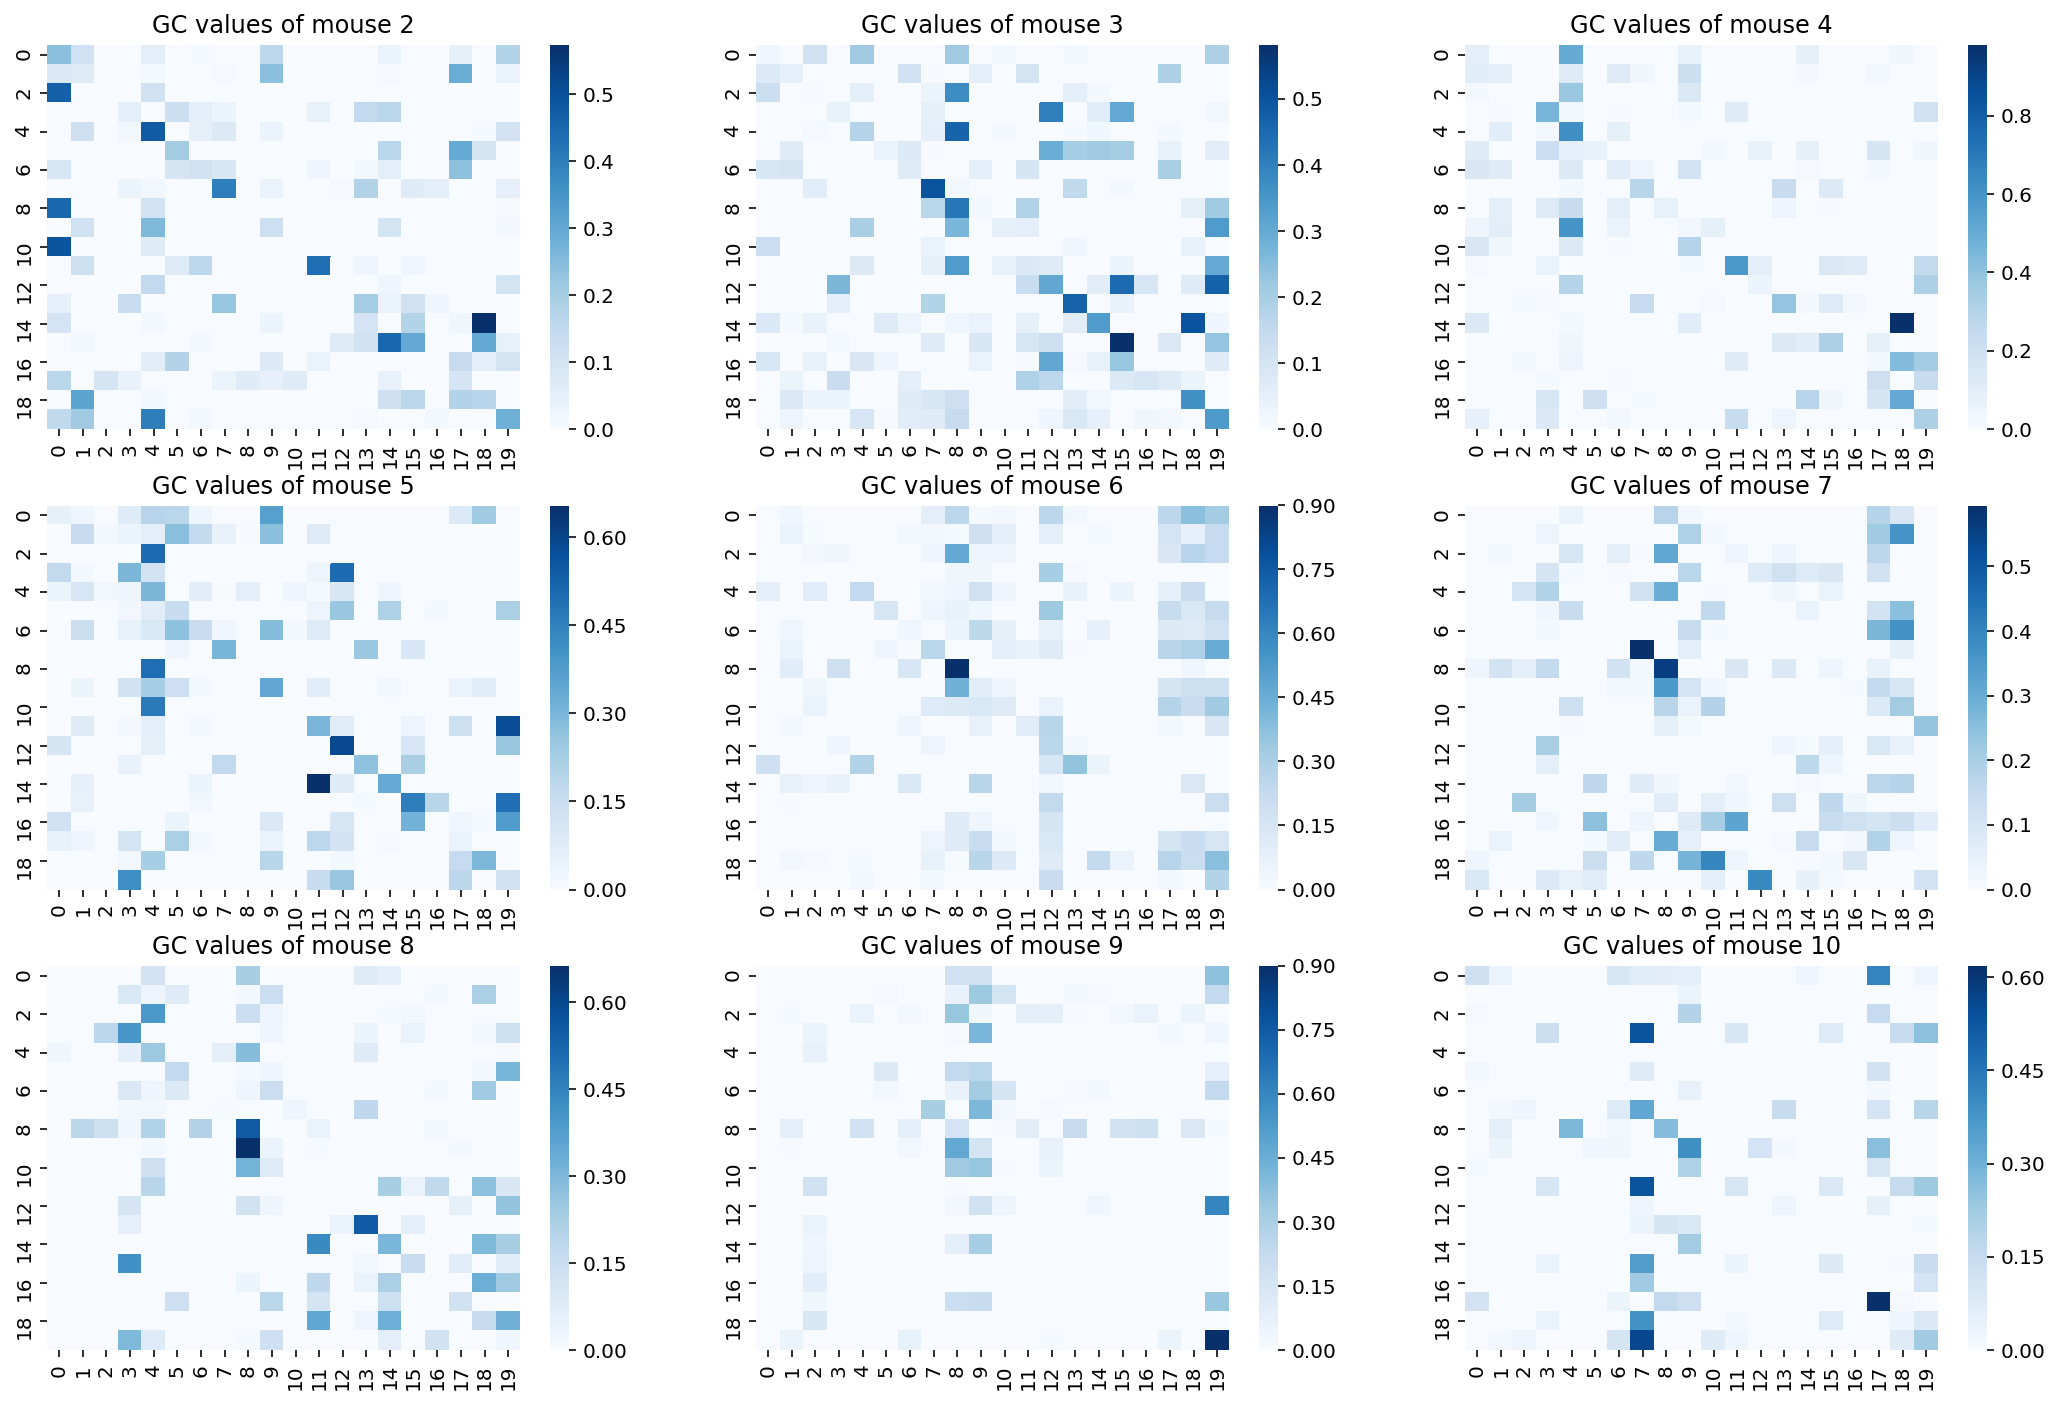

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for iax, ax in enumerate(axes.ravel()):
    sns.heatmap(heatmaps[iax,-1], ax=ax, cmap='Blues')
    ax.set_title(f'GC values of mouse {iax+2}')

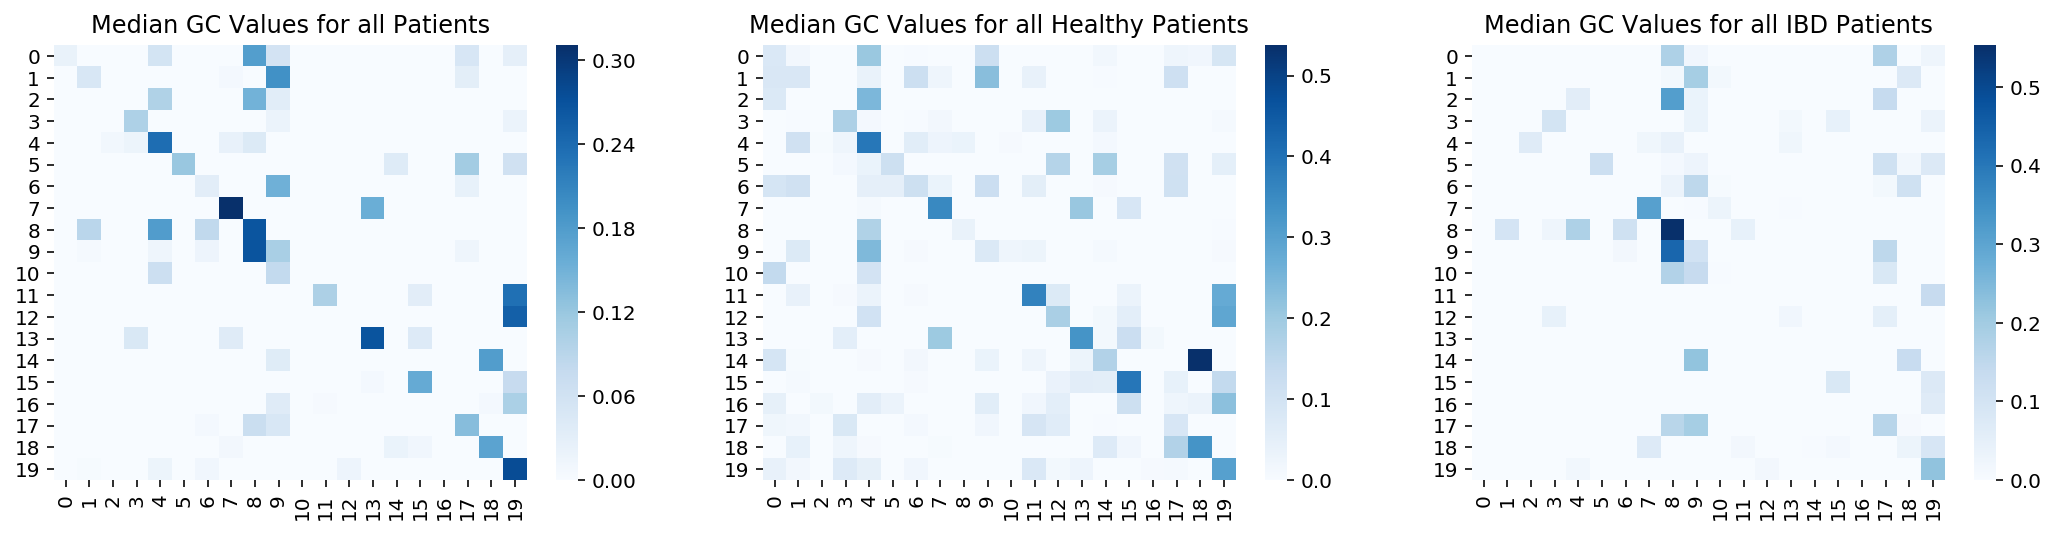

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))

sns.heatmap(np.median([heatmaps[i,-1] for i in range(9)], axis=0), ax=axes[0], cmap='Blues')
axes[0].set_title('Median GC Values for all Patients')

sns.heatmap(np.median([heatmaps[i,-1] for i in range(4)], axis=0), ax=axes[1], cmap='Blues')
axes[1].set_title('Median GC Values for all Healthy Patients')

sns.heatmap(np.median([heatmaps[i,-1] for i in range(4,9)], axis=0), ax=axes[2], cmap='Blues')
axes[2].set_title('Median GC Values for all IBD Patients')

plt.show()

Instead of looking at all interactions, and since some values are quite small, we can also consider the top 20 median values in each category.

In [27]:
def topk_median_indicators(heatmaps, k):
    median = np.median(heatmaps[:,-1], axis=0)
    return (median >= np.partition(median.reshape(-1), -k)[-k]).astype('float')

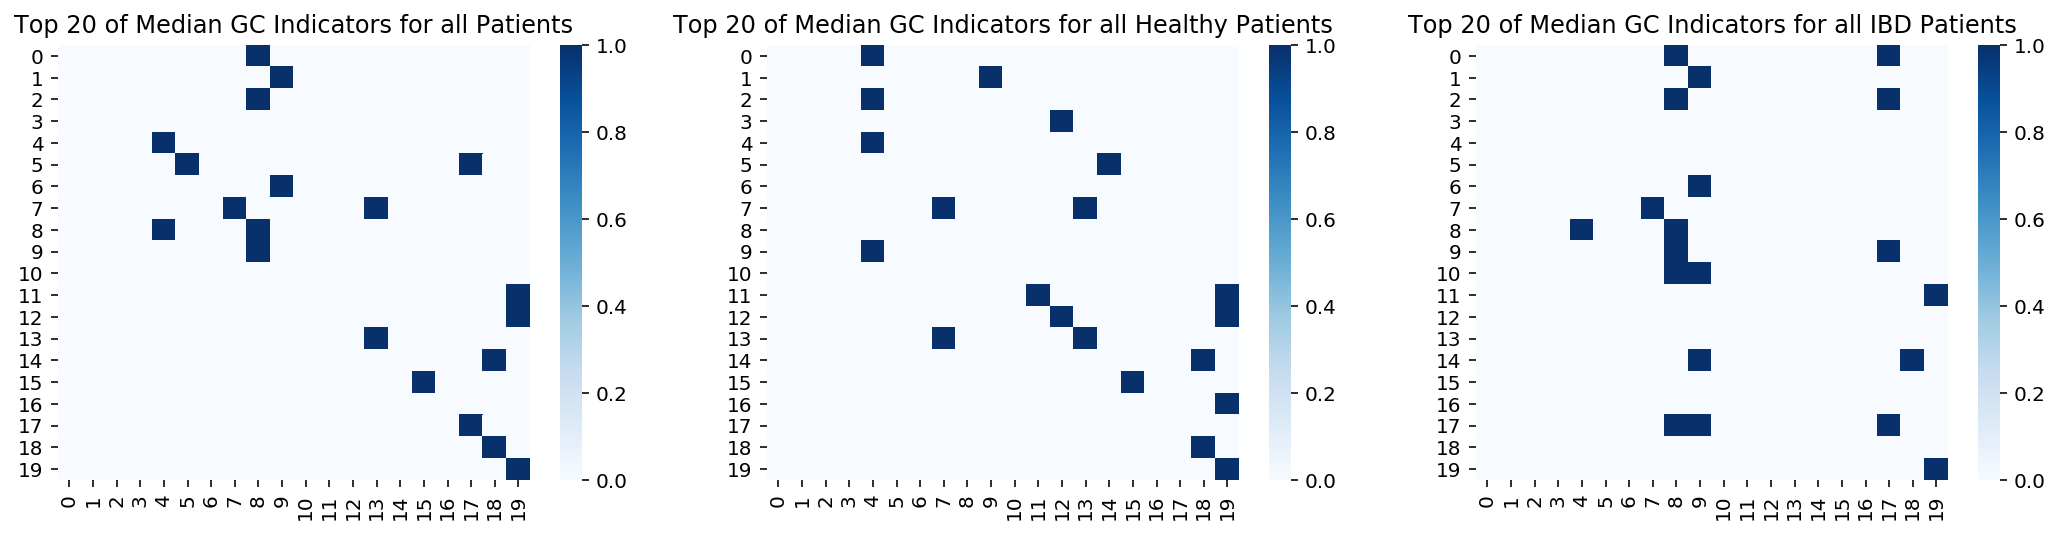

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))

sns.heatmap(topk_median_indicators(heatmaps, 20), cmap='Blues', ax=axes[0])
axes[0].set_title('Top 20 of Median GC Indicators for all Patients')

sns.heatmap(topk_median_indicators(heatmaps[:4], 20), cmap='Blues', ax=axes[1])
axes[1].set_title('Top 20 of Median GC Indicators for all Healthy Patients')

sns.heatmap(topk_median_indicators(heatmaps[4:], 20), cmap='Blues', ax=axes[2])
axes[2].set_title('Top 20 of Median GC Indicators for all IBD Patients')

plt.show()